In [9]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from dataclasses import dataclass, field
from typing import List, Optional, Tuple
import numpy as np


crater_dtype = np.dtype([
('radius', 'f4'),          # float32 for crater radius
('y_position', 'f4'),      # float32 for y-axis position
('time_formed', 'i4'),     # int32 for timestamp
('depth', 'f4'),           # float32 for crater depth
])
    
@dataclass
class EDMState:
    # Time tracking
    time: int = 0 # Current time from start of simulation
    time_since_servo: int = 0 # Time since last servo action
    time_since_open_voltage: int = 0  # Time since last voltage was applied
    time_since_spark_ignition: int = 0 # Time since last spark was ignited
    time_since_spark_end: int = 0 # Time since last spark ended
    
    
    # Electrical state variables
    voltage: Optional[float] = None
    current: Optional[float] = None
    
    # Generator control state variables
    target_voltage: Optional[float] = None
    peak_current: Optional[float] = None
    OFF_time: Optional[float] = None
    ON_time: Optional[float] = None

    # Workpiece state variables
    
    workpiece_position: float = 0 # Current position of the workpiece
    
    # Wire state variables
    wire_position: float = 0.0 # Current position of the wire
    wire_velocity: float = 0.0 # Current velocity of the wire
    wire_unwinding_velocity = 0.2 # Unwinding velocity of the wire in micrometers per microsecond (microns/μs -- mm/ms .. m/s)
    wire_temperature: np.ndarray = field(default_factory=lambda: np.array([], dtype=np.float32))
    time_in_critical_temp: int = 0
    
    
    # Spark state variables
    
    # Tuple to track current spark status (state, y-location, duration)
    # state: 0=No event, 1=Spark formation, -1=Short circuit, -2=Rest period
    # y_location: Position along wire length where spark is occurring (None if no spark)
    # duration: How many timesteps the current spark state has existed
    
    spark_status: List[Optional[float]] = field(default_factory=lambda: [0, None, 0])

    
    # Dielectric state variables
    
    dielectric_conductivity: float = 0.0 # Conductivity of the dielectric
    dielectric_temperature: float = 0.0 # Temperature of the dielectric
    debris_concentration: float = 0.0 # Concentration of debris in the dielectric
    dielectric_flow_rate: float = 0.0 # Flow rate of the dielectric
    ionized_channel: Optional[Tuple[float, int]] = None # (y_location, time_remaining) or None
    
    # Servo state variables
    
    target_delta: float = 0.0 # Target change in position for the servo in the linear axis. This is the main servo control signal.
    
    # Target position for the servo in the linear axis. This is the main servo control signal.
    target_position: float = 500
    
    # Process state
    is_wire_broken: bool = False
    is_wire_colliding: bool = False
    is_target_distance_reached: bool = False


class EDMModule:
    """Base class for all EDM simulation modules"""
    def __init__(self, env):
        self.env = env

    def update(self, state: EDMState) -> None:
        pass
    
class IgnitionModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        self.lambda_cache = {}  # Cache for lambda values
        
    def update(self, state: EDMState) -> None:
        
        # First, unpack the generator control state
        target_voltage = state.target_voltage
        peak_current = state.peak_current
        
        ON_time = state.ON_time if state.ON_time is not None else 3  # Default to 3
        OFF_time = state.OFF_time if state.OFF_time is not None else 80  # Default to 80
        
        # Check for physical short circuit (wire touching workpiece)
        if state.wire_position >= state.workpiece_position:
            state.spark_status = [-1, None, 0]
            state.voltage = 0
            state.current = state.peak_current
            return

        # Check spark status in the previous timestep
        spark_state, spark_location, spark_duration = state.spark_status
        
        # # Check for ionized channel short circuit
        # if state.ionized_channel is not None:
        #     y_loc, time_remaining = state.ionized_channel
        #     # Treat ionized channel as a short circuit
        #     state.spark_status = [-1, y_loc, 0]
        #     state.voltage = 0
        #     state.current = state.peak_current
        #     return
            
        # # Check for debris-induced short circuit
        # if self.env.np_random.random() < state.debris_concentration * 0.1: # Scale factor of 0.1 for probability
        #     state.spark_status = [-1, None, 0]
        #     state.voltage = 0 
        #     state.current = state.peak_current
        #     return
        
        
        # Suppose spark is already present, maintain it until current is cut
        if spark_state == 1: # If spark is happening
            state.spark_status = [1, spark_location, spark_duration + 1] # Increment counter
            if state.spark_status[2] >= ON_time: # End of spark duration
                state.spark_status[0] = -2 # Start rest period
                state.current = 0
                state.voltage = 0
            else:
                state.current = peak_current
                state.voltage = target_voltage * 0.3
            return
        
        if spark_state == -2: # If in rest period
            state.spark_status = [-2, None, spark_duration + 1]
            if state.spark_status[2] >= OFF_time + ON_time:  # End of rest period
                state.spark_status = [0, None, 0]
                state.voltage = target_voltage
                state.current = 0
            return
        
        if spark_state == 0: # No spark happening and not in rest period
            state.voltage = target_voltage
            state.current = 0
            # Calculate probability of new spark formation
            p_ignition = self._get_spark_conditional_probability(state)
    
            # Sample from probability distribution
            if self.env.np_random.random() < p_ignition:
                # Ignition occurs - randomly choose location along wire height
                
                spark_location = self.env.np_random.uniform(0, self.env.workpiece_height)

                state.spark_status = [1, spark_location, 0]
                state.voltage = state.target_voltage * 0.3  # Voltage drops during discharge
                state.current = state.peak_current
            else:
                # No ignition
                state.spark_status = [0, None, 0]
                state.voltage = state.target_voltage
                state.current = 0
    
    def _get_spark_conditional_probability(self, state):
        """ Calculate the conditional probability of sparking at a given microsecond,
        given that it has not sparked yet since the last voltage rise."""

        # In the case of the exponential distribution, the conditional
        # probability is just lambda
        return self._get_lambda(state)
    
    def _get_lambda(self, state):
        gap_distance = abs(state.workpiece_position - state.wire_position)
        # Check cache first
        if gap_distance in self.lambda_cache:
            return self.lambda_cache[gap_distance]
        # Calculate new lambda value and cache it
        lambda_value = np.log(2)/(0.48*gap_distance*gap_distance - 3.69*gap_distance + 14.05)
        self.lambda_cache[gap_distance] = lambda_value
        
        return lambda_value

# Add other modules similarly
class MaterialRemovalModule(EDMModule):
    # TODO: Add crater formation and removal rate based on spark energy
    def update(self, state):
        # Only remove material if there is an active spark that just started
        if state.spark_status[0] == 1 and state.spark_status[2] == 0:
            # Remove a constant amount of material by moving the workpiece position
            # away from the wire by a small fixed increment
            removal_rate = 0.05  # mm per spark
            state.workpiece_position += removal_rate

class DielectricModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        # Dielectric state variables
        self.dielectric_temp = 293.15  # Dielectric temperature in K
        self.debris_concentration = 0.0  # Debris concentration (0-1) 
        self.flow_rate = 1.0  # Normalized flow rate (0-1)
        self.ionized_channel = None  # (y_location, time_remaining) or None
        
        # Model parameters
        self.beta = 1e-3  # Debris concentration increase per mm^3 of crater volume
        self.gamma = 5e-4  # Base debris decay rate per microsecond at flow_rate=1
        self.tau_deionization = 6  # Deionization time in microseconds
        
    def update(self, state):
        # Update dielectric temperature
        state.dielectric_temperature = self.dielectric_temp
        
        # Handle debris concentration
        # Add debris if there was a spark that just started
        if state.spark_status[0] == 1 and state.spark_status[2] == 0:
            # Get crater volume from material removal module (placeholder value for now)
            crater_volume = 0.1  # mm^3
            self.debris_concentration = min(1.0, 
                self.debris_concentration + self.beta * crater_volume)
            
            # Create new ionized channel
            self.ionized_channel = (state.spark_status[1], self.tau_deionization)
            
        # Update ionized channel state
        if self.ionized_channel:
            y_loc, time_remaining = self.ionized_channel
            if time_remaining > 0:
                self.ionized_channel = (y_loc, time_remaining - 1)
            else:
                self.ionized_channel = None
                
        # Clear debris based on flow rate (exponential decay)
        self.debris_concentration *= (1 - self.gamma * self.flow_rate)
        self.debris_concentration = max(0.0, self.debris_concentration)
        
        # Update state variables
        state.debris_concentration = self.debris_concentration
        state.flow_rate = self.flow_rate
        state.ionized_channel = self.ionized_channel
        
        

class WireModule(EDMModule):
    def __init__(
        self,
        env,
        buffer_length_bottom: float = 50.0,  # Changed from top to bottom since this is the spool side
        buffer_length_top: float = 50.0,     # Changed from bottom to top since this is the exit side
        spool_temperature: float = 293.15,
        segment_length: float = 0.2,
    ):
        super().__init__(env)
        
        # Configuration
        self.buffer_length_bottom = buffer_length_bottom  # Changed from top to bottom
        self.buffer_length_top = buffer_length_top        # Changed from bottom to top
        self.spool_temperature = spool_temperature
        
        # Geometry for the thermal model
        
        self.segment_length = segment_length
        self.total_wire_length = (
            self.buffer_length_bottom  # Changed order to match physical layout
            + env.workpiece_height
            + self.buffer_length_top
        )
        
        self.n_segments = int(self.total_wire_length / self.segment_length)
        
        self.working_zone_start_idx = int(self.buffer_length_bottom // self.segment_length)  # Changed from top to bottom
        self.working_zone_end_idx = self.working_zone_start_idx + int(
            env.workpiece_height // self.segment_length
        )
        
        self.wire_radius = env.wire_diameter / 2.0
        
        # Initialize wire T if needed
        if len(env.state.wire_temperature) == 0:
            env.state.wire_temperature = np.full(
                self.n_segments, self.spool_temperature, dtype=np.float32
            )
        elif len(env.state.wire_temperature) < self.n_segments:
            env.state.wire_temperature = np.full(
                self.n_segments, self.spool_temperature, dtype=np.float32
            )
        
        # Material & geometry
        self.rho = 8400  # kg/m³ (density)
        self.cp = 377    # J/(kg·K) (specific heat capacity)
        self.k = 120     # W/(m·K) (thermal conductivity)
        self.melting_point = 1180  # K (melting temperature)
        self.rho_electrical = 6.4e-8  # Ω·m (electrical resistivity at room temp)
        self.alpha_resistivity = 0.0039  # 1/K (temperature coefficient of resistivity)
        
        self.h_convection = 14000  # W/(m²·K) (convective heat transfer coefficient)
        self.eta_plasma = 0.1      # dimensionless (plasma heating efficiency)
        
        self.critical_temp = 100     # K (critical temperature rise)
        self.critical_duration = 1e6  # µs (critical duration)
        
        self.delta_y = self.segment_length * 1e-3  # m (segment length)
        self.S_wire = np.pi * (self.wire_radius * 1e-3) ** 2  # m² (wire cross-section)
        self.A_wire = 2.0 * np.pi * (self.wire_radius * 1e-3) * self.delta_y  # m² (segment surface area)
        self.conduction_coeff = (self.k * self.S_wire) / self.delta_y  # W/K (conduction coefficient)
        
        # Precompute mass * heat capacity * segment length
        self.denominator = self.rho * self.cp * self.S_wire * self.delta_y

    def update(self, state: EDMState) -> None:
        if state.is_wire_broken:
            return
        
        T = state.wire_temperature
        current = state.current if state.current is not None else 0.0
        dt_s = 1e-6  # 1 µs in seconds
        
        # ------------------------------
        # 1) Enforce boundary conditions in-place
        #    (fix top & bottom nodes to spool temp)
        # ------------------------------
        T[0] = self.spool_temperature
        T[-1] = self.spool_temperature
        
        # ------------------------------
        # 2) Compute conduction term
        #    conduction = k * A / dy * (T[i-1] - 2T[i] + T[i+1])
        # ------------------------------
        T_left = np.roll(T, 1)
        T_right = np.roll(T, -1)
        
        # We can manually fix the boundary conduction to 0 if we want:
        # T_left[0] = T[0], T_right[-1] = T[-1]  # or just leave it because we pinned T anyway
        # But typically the pinned T is enough.
        
        q_cond = self.conduction_coeff * (T_left - 2.0 * T + T_right)
        
        # ------------------------------
        # 3) Compute Joule heating (vector)
        #    Q_joule = I^2 * R_segment
        #    R_segment = rho_electrical(T) * (delta_y / S_wire)
        # ------------------------------
        # Resistivity at T
        rho_elec_T = self.rho_electrical * (1.0 + self.alpha_resistivity * (T - 293.15))
        q_joule = (current**2) * rho_elec_T * (self.delta_y / self.S_wire)
        # If you want that 0.5 factor, do it here
        q_joule *= 0.5
        
        # ------------------------------
        # 4) Plasma heat in the "working zone"
        #    Only one segment gets the spark heat
        # ------------------------------
        q_plasma = np.zeros_like(T)
        if state.spark_status[0] == 1 and state.spark_status[1] is not None:
            spark_y = state.spark_status[1]  # 0..workpiece_height
            spark_idx = self.working_zone_start_idx + int(spark_y // self.segment_length)
            spark_idx = np.clip(spark_idx, 0, self.n_segments - 1)
            q_plasma[spark_idx] = self.eta_plasma * state.voltage * current
        
        # ------------------------------
        # 5) Convection term
        #    q_conv = h * A_wire * (T - T_fluid)
        #    Possibly scale h by wire velocity
        # ------------------------------
        h_effective = self.h_convection * (1.0 + 0.5 * state.wire_unwinding_velocity)
        q_conv = h_effective * self.A_wire * (T - state.dielectric_temperature)
        
        # ------------------------------
        # 6) Transport (advection) along the wire
        #    q_transport = rho cp v S (T[i+1] - T[i]) / dy
        #    with i+1 = T_right
        # ------------------------------
        v_wire = state.wire_unwinding_velocity  # microns/µs
        # convert velocity to m/s
        v_m_s = v_wire * 1e-3
        
        q_transport = (
            self.rho * self.cp * v_m_s * self.S_wire / self.delta_y
        ) * (T_right - T)
        
        # ------------------------------
        # 7) Combine fluxes and update T in a single pass
        #    net_heat = q_plasma + q_joule + q_cond - q_conv + q_transport
        # ------------------------------
        net_heat = q_plasma + q_joule + q_cond - q_conv + q_transport
        
        dT_dt = net_heat / self.denominator
        T_new = T + dT_dt * dt_s
        
        # ------------------------------
        # 8) Update T array in place
        #    Re‐enforce boundary
        # ------------------------------
        T[:] = T_new
        T[0] = self.spool_temperature
        T[-1] = self.spool_temperature
        
        # ------------------------------
        # 9) Average temperature in the working zone
        # ------------------------------
        zone_slice = T[self.working_zone_start_idx : self.working_zone_end_idx]
        if len(zone_slice) > 0:
            state.wire_average_temperature = float(np.mean(zone_slice))
        else:
            state.wire_average_temperature = float(np.mean(T))



## Mechanics Module
class MechanicsModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        self.omega_n = 100.0      # Natural frequency in rad/s - typical for precision EDM servos
        self.zeta = 0.75          # Slightly underdamped system
        self.max_accel = 0.1 * 9.81 * 10**6  # Maximum acceleration in µm/s² (0.5g)
        self.max_jerk = 300 * self.max_accel       # Maximum jerk in µm/s³
        self.max_speed = 3e6                 # Maximum speed in µm/s (3 m/s)
        self.previous_accel = 0.0

    def update(self, state):
        """
        Update the mechanical state of the workpiece using a second-order servo dynamic model:
            x'' + 2ζωₙ x' + ωₙ² (x - x_target) = 0
        where:
            x is the current workpiece position (state.wire_position),
            x_target is the commanded target position (state.target_delta),
        The integration is performed with Euler's method, and the acceleration is
        limited both in magnitude (saturation) and in its rate of change (jerk capping).
        """
        # Convert timestep from microseconds to seconds
        dt_sec = self.env.dt * 1e-6
        
        # Retrieve current position and target
        x = state.wire_position
        x_target = x + state.target_delta
        
        # Compute nominal acceleration based on the servo dynamics model
        accel_nom = -2.0 * self.zeta * self.omega_n * state.wire_velocity - self.omega_n**2 * (x - x_target)
        
        # First, clip the nominal acceleration to the maximum allowed acceleration
        accel_nom = np.clip(accel_nom, -self.max_accel, self.max_accel)
        
        # Compute the change in acceleration (jerk) required to reach accel_nom
        delta_accel = accel_nom - self.previous_accel
        # Calculate the maximum allowed change in acceleration for this timestep
        max_delta = self.max_jerk * dt_sec
        # Cap the change in acceleration (i.e. the jerk)
        delta_accel = np.clip(delta_accel, -max_delta, max_delta)
        
        # Apply the capped change in acceleration
        accel = self.previous_accel + delta_accel
        
        # Store the current acceleration for use in the next update cycle
        self.previous_accel = accel
        
        # Update velocity using Euler integration
        state.wire_velocity += accel * dt_sec
        # Limit the velocity to the maximum allowed speed (parameterized)
        state.wire_velocity = np.clip(state.wire_velocity, -self.max_speed, self.max_speed)
        
        # Update position using Euler integration
        x_new = x + state.wire_velocity * dt_sec
        
        # Update the workpiece position in state
        state.wire_position = x_new

# Definition of the EDM environment
class WireEDMEnv(gym.Env):    
    metadata = {"render_modes": ["human"], "render_fps": 300}
    
    def __init__(self, render_mode=None):
        self.render_mode = render_mode
        # Simulation parameters
        ## Internal timestep parameters
        self.dt = 1 # Base timestep (1μs)
        self.servo_interval = 1000 # Servo interval (1ms)
        
        ## Process configuration
        ### Workpiece physical properties
        self.workpiece_height = 10 # Height of workpiece (mm)
        self.workpiece_material = 'steel' # Material of workpiece
        #...
        
        ### Wire physical properties
        self.wire_material = 'brass'
        self.wire_diameter = 0.25 # Diameter of wire (mm)
        #...
        
        ### Dielectric physical properties
        self.dielectric_material = 'deionized water'
        
        self.state = EDMState() # Initialize state of the simulation
        
        self.ignition_module = IgnitionModule(self)
        self.material_removal_module = MaterialRemovalModule(self)
        self.dielectric_module = DielectricModule(self)
        self.wire_module = WireModule(self)
        self.mechanics_module = MechanicsModule(self)
        
        self.action_space = spaces.Dict({
            'servo': spaces.Box(
                low=np.array([-1.0]),
                high=np.array([1.0]),
                dtype=np.float32
            ),
            'generator_control': spaces.Dict({
                'target_voltage': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([200.0]),  # Placeholder max voltage
                    dtype=np.float32
                ),
                'peak_current': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([100.0]),  # Placeholder max current
                    dtype=np.float32
                ),
                'ON_time': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([5.0]),  # Placeholder max on time
                    dtype=np.float32
                ),
                'OFF_time': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([100.0]),  # Placeholder max off time
                    dtype=np.float32
                )
            })
        })
    
    def _check_termination(self):
        # Check for wire breakage
        if self.state.wire_position > self.state.workpiece_position + 100:  # Adding a 100 micrometers margin
            self.state.is_wire_broken = True
            return True
        
        # Check for target distance reached
        if self.state.workpiece_position >= self.state.target_position:
            self.state.is_target_distance_reached = True
            return True
        
        return False
    
    def _get_obs(self):
        return None
        
    def _calculate_reward(self):
        return 0
    
    def step(self, action):
        # Track if this is a control step (every 1ms / 1000μs)
        is_control_step = self.state.time_since_servo >= self.servo_interval
        
        # Only process actions on control steps
        if is_control_step:
            self.state.target_delta = action['servo'][0]
            self.state.target_voltage = action['generator_control']['target_voltage'][0]
            self.state.peak_current = action['generator_control']['peak_current'][0]
            self.state.ON_time = action['generator_control']['ON_time'][0]  # Add these two lines
            self.state.OFF_time = action['generator_control']['OFF_time'][0]
            self.state.time_since_servo = 0  # Reset timer
        
        # Sequential process updates
        self.ignition_module.update(self.state)
        self.material_removal_module.update(self.state)
        self.dielectric_module.update(self.state)
        self.wire_module.update(self.state)
        if self.state.is_wire_broken:
            # If the wire is broken, return immediately
            return None, 0, True, False, {'wire_broken': True}
        self.mechanics_module.update(self.state)
        
        # Update time trackers
        self.state.time += self.dt
        self.state.time_since_servo += self.dt
        self.state.time_since_open_voltage += self.dt
        
        if self.state.spark_status[0] == 1:
            self.state.time_since_spark_ignition += self.dt
            self.state.time_since_spark_end = 0
        else:
            self.state.time_since_spark_end += self.dt
            self.state.time_since_spark_ignition = 0
        
        # Only return meaningful observations and calculate rewards on control steps
        if is_control_step:
            observation = self._get_obs()
            reward = self._calculate_reward()
            self.previous_target_current = self.state.peak_current
        else:
            observation = None
            reward = 0
        
        terminated = self._check_termination()
        truncated = False
        
        info = {
            'wire_broken': self.state.is_wire_broken,
            'target_reached': self.state.is_target_distance_reached,
            'spark_status': self.state.spark_status[0],
            'time': self.state.time,
            'is_control_step': is_control_step
        }
        
        return observation, reward, terminated, truncated, info


Simulation completed all iterations without termination. Total simulation time: 11.705598592758179 seconds


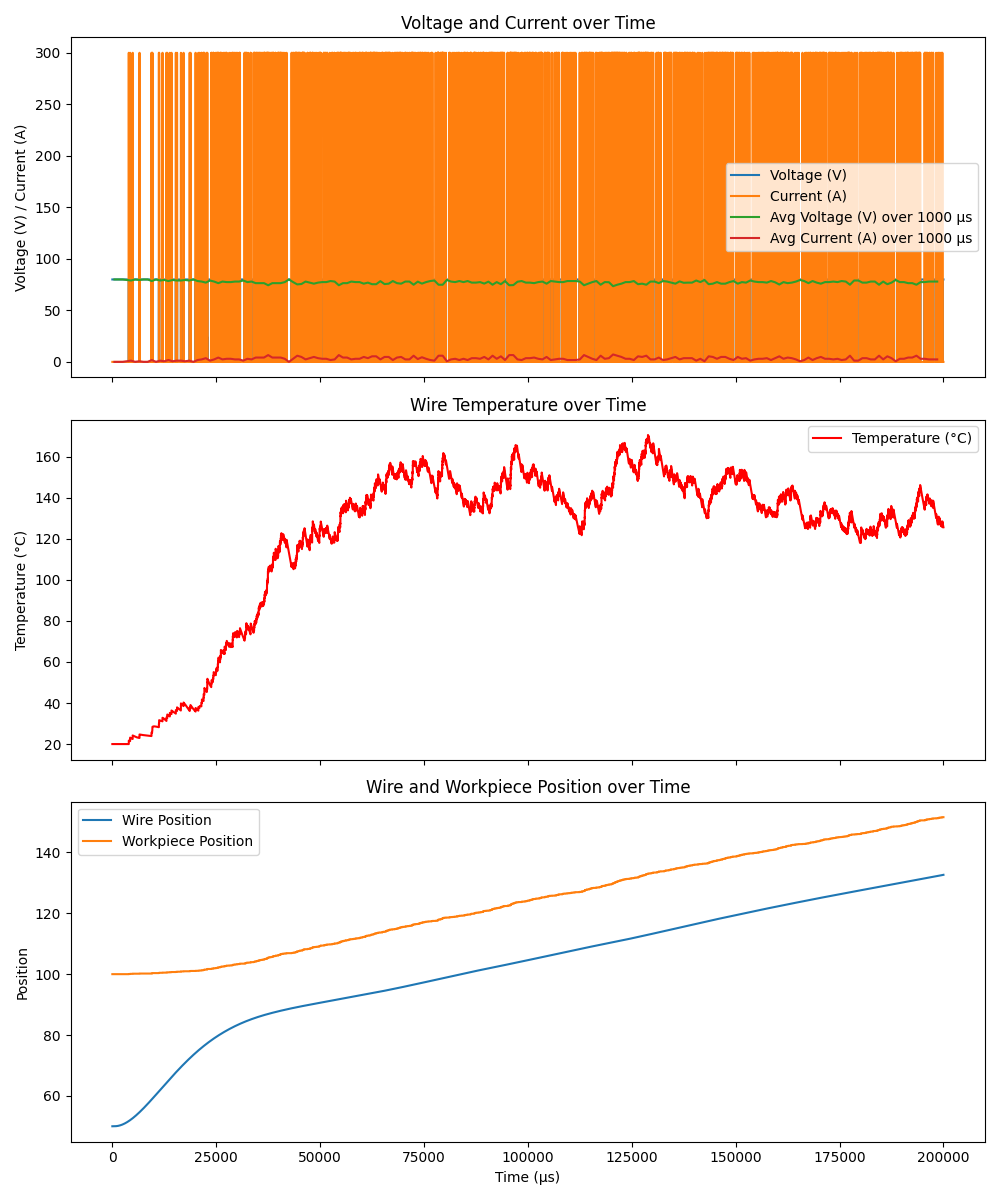

In [7]:
import matplotlib.pyplot as plt
import time
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter

# %matplotlib widget  
env = WireEDMEnv()
env.state.workpiece_position = 100
env.state.wire_position = 50
env.state.target_voltage = 80
env.state.peak_current = 300
env.state.OFF_time = 10
env.state.target_position = 5000

voltage_history = []
current_history = []
time_history = []
temperature_history = []
wire_temperature_evolution = []
wire_position_history = []         # Record the wire position over time
workpiece_position_history = []    # Record the workpiece position over time

start_time = time.time()
terminated_flag = False
N = 200000
for i in range(N):  # 1 seconds of simulation at 1μs timesteps
    # Define the desired gap between wire and workpiece
    desired_gap = 15
    # Set target_delta so that the wire is positioned at workpiece_position minus the desired gap
    env.state.target_delta = env.state.workpiece_position - desired_gap - env.state.wire_position
    action = {
        'servo': np.array([0.0], dtype=np.float32),
        'generator_control': {
            'target_voltage': np.array([80.0], dtype=np.float32),
            'peak_current': np.array([300.0], dtype=np.float32),
            'ON_time': np.array([2.0], dtype=np.float32),
            'OFF_time': np.array([5.0], dtype=np.float32)
        }
    }
    observation, reward, terminated, truncated, info = env.step(action)
    
    voltage_history.append(env.state.voltage)
    current_history.append(env.state.current)
    time_history.append(env.state.time)
    temperature_history.append(env.state.wire_average_temperature)
    wire_temperature_evolution.append(env.state.wire_temperature.copy())
    wire_position_history.append(env.state.wire_position)         # Log wire position
    workpiece_position_history.append(env.state.workpiece_position)   # Log workpiece position
    
    if terminated:
        print(f"Simulation terminated at iteration {i}. Reason: {info}")
        terminated_flag = True
        break

end_time = time.time()

if not terminated_flag:
    print(f"Simulation completed all iterations without termination. Total simulation time: {end_time - start_time} seconds")
else:
    print(f"Simulation ran for {end_time - start_time} seconds until termination.")

# Calculate average voltage and current over 1000 μs windows
window_size = 1000
avg_voltage_history = []
avg_current_history = []
avg_time_history = []

for i in range(0, len(voltage_history) - window_size, window_size):
    avg_voltage_history.append(np.mean(voltage_history[i:i+window_size]))
    avg_current_history.append(np.mean(current_history[i:i+window_size]))
    avg_time_history.append(np.mean(time_history[i:i+window_size]))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)  # Added sharex=True

# Plot voltage and current on first subplot
ax1.plot(time_history, voltage_history, label="Voltage (V)")
ax1.plot(time_history, current_history, label="Current (A)")
ax1.plot(avg_time_history, avg_voltage_history, label="Avg Voltage (V) over 1000 μs")
ax1.plot(avg_time_history, avg_current_history, label="Avg Current (A) over 1000 μs")
ax1.set_ylabel("Voltage (V) / Current (A)")
ax1.set_title("Voltage and Current over Time")
ax1.legend()

# Plot temperature on second subplot
ax2.plot(time_history, [temp - 273.15 for temp in temperature_history], label="Temperature (°C)", color='red')
ax2.set_ylabel("Temperature (°C)")
ax2.set_title("Wire Temperature over Time")
ax2.legend()

# Plot wire and workpiece positions on third subplot
ax3.plot(time_history, wire_position_history, label="Wire Position")
ax3.plot(time_history, workpiece_position_history, label="Workpiece Position")
ax3.set_xlabel("Time (μs)")
ax3.set_ylabel("Position")
ax3.set_title("Wire and Workpiece Position over Time")
ax3.legend()

plt.tight_layout()
plt.show()


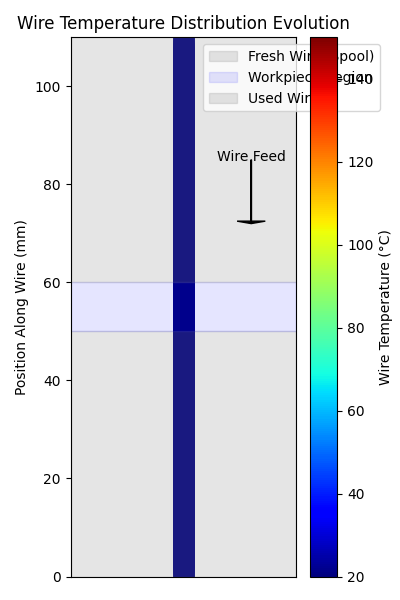

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
%matplotlib widget
# --- Precompute all static elements first ---
# Convert temperatures once upfront
wire_temps_celsius = (np.array(wire_temperature_evolution) - 273.15)
time_points = np.array(time_history)

# --- Adjusted Normalization ---
norm = plt.Normalize(vmin=20, vmax=150)

# --- Setup the figure ---
fig_anim, ax_anim = plt.subplots(figsize=(4, 6))

# Get environment parameters
buffer_length_top = env.wire_module.buffer_length_top
buffer_length_bottom = env.wire_module.buffer_length_bottom
workpiece_height = env.workpiece_height
total_length = buffer_length_bottom + workpiece_height + buffer_length_top

n_segments = len(env.state.wire_temperature)
wire_positions = np.linspace(0, total_length, n_segments)
# --- Create colormap ---
cmap = plt.cm.jet

# Initial scatter plot
scat = ax_anim.scatter(
    np.zeros_like(wire_positions),
    wire_positions,
    c=wire_temps_celsius[0],
    cmap=cmap,
    norm=norm,
    s=200,
    marker='s'
)

# --- Configure plot ---
cbar = plt.colorbar(scat, ax=ax_anim)
cbar.set_label('Wire Temperature (°C)')

ax_anim.set_ylabel("Position Along Wire (mm)")
ax_anim.set_title("Wire Temperature Distribution Evolution")
ax_anim.set_xticks([])
ax_anim.set_xlim(-0.2, 0.2)
ax_anim.set_ylim(0, total_length)

# Add shaded regions - corrected order to match physical layout
ax_anim.axhspan(0, buffer_length_bottom, color='gray', alpha=0.2, label='Fresh Wire (Spool)')
ax_anim.axhspan(buffer_length_bottom, buffer_length_bottom + workpiece_height, 
                color='blue', alpha=0.1, label='Workpiece Region')
ax_anim.axhspan(buffer_length_bottom + workpiece_height, total_length, color='gray', alpha=0.2, 
                label='Used Wire')
# Add direction arrow
ax_anim.arrow(0.12, total_length - buffer_length_top/2, 0, -buffer_length_top/4,
              head_width=0.05, head_length=0.5, fc='k', ec='k')
ax_anim.text(0.06, total_length - buffer_length_top/2 + 0.5, 'Wire Feed', va='center')

ax_anim.legend(bbox_to_anchor=(1.4, 1), loc='upper right')

# Calculate frames and skip based on desired duration
desired_fps = 20
desired_duration = 30  # seconds
total_frames = min(desired_fps * desired_duration, len(wire_temps_celsius))
skip = max(1, len(wire_temps_celsius) // total_frames)

# --- Animation update function ---
def update(frame):
    actual_frame = min(frame * skip, len(wire_temps_celsius) - 1)
    scat.set_array(wire_temps_celsius[actual_frame])
    ax_anim.set_title(f"Wire Temperature - Time: {time_points[actual_frame]:.0f} μs")
    return (scat,)

# Create animation
anim = FuncAnimation(fig_anim, update, frames=total_frames,
                    interval=1000/desired_fps, blit=True)

# Display animation in notebook
plt.tight_layout()
plt.show()

In [ ]:

## SERVO DESIGN PLAYGROUND

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget

# Test cell for Mechanics Module servo dynamics with dynamic target updates.
# The servo dynamics follow the second-order differential equation:
#   x'' + 2ζωₙ x' + ωₙ² (x - x_d) = 0
# where x is the current position, x_d is the target (commanded) position,
# ωₙ is the natural frequency, and ζ is the damping ratio.
#
# In this simulation, every millisecond the target distance is modified by a random
# increment uniformly drawn from the range [-5, 5] micrometers.

# Simulation parameters
omega_n = 100.0      # Natural frequency in rad/s - typical for precision EDM servos
zeta = 0.75          # Slightly underdamped system
initial_target = 200.0  # Initial target position in micrometers

# Initial conditions
x = 0.0               # Initial position (in micrometers)
v = 0.0               # Initial velocity (in micrometers per second)
current_target = initial_target  # Current target position

dt = 1e-6             # Integration timestep (1 microsecond)
T_total = 0.40         # Total simulation time in seconds
n_steps = int(T_total / dt)

# Arrays to record simulation data
time_arr = np.zeros(n_steps)
pos_arr = np.zeros(n_steps)
vel_arr = np.zeros(n_steps)
target_arr = np.zeros(n_steps)  # Records target position over time

# Acceleration and jerk limits
max_accel = 0.1 * 9.81 * 10**6  # Maximum acceleration in µm/s² (0.5g)
max_jerk = 300 * max_accel       # Maximum jerk in µm/s³
max_speed = 3e6                 # Maximum speed in µm/s (3 m/s)
previous_accel = 0.0            # Track previous acceleration for jerk limiting

for i in range(n_steps):
    t = i * dt
    # Update the target position every millisecond (every 1000 steps)
    if i % 1000 == 0:
        if i != 0:
            # Increment the target by a random value uniformly drawn from [-5, 5] micrometers
            current_target += np.random.uniform(-5, 5)
    target_arr[i] = current_target

    time_arr[i] = t
    pos_arr[i] = x
    vel_arr[i] = v

    # Compute nominal acceleration using the servo dynamics:
    # a = -2ζωₙ*v - ωₙ²*(x - current_target)
    accel_nom = -2 * zeta * omega_n * v - (omega_n ** 2) * (x - current_target)
    
    # First, clip the nominal acceleration to the maximum allowed acceleration
    accel_nom = np.clip(accel_nom, -max_accel, max_accel)
    
    # Compute the change in acceleration (jerk) required to reach accel_nom
    delta_accel = accel_nom - previous_accel
    # Calculate the maximum allowed change in acceleration for this timestep
    max_delta = max_jerk * dt
    # Cap the change in acceleration (i.e. the jerk)
    delta_accel = np.clip(delta_accel, -max_delta, max_delta)
    
    # Apply the capped change in acceleration
    a = previous_accel + delta_accel
    
    # Store the current acceleration for use in the next update cycle
    previous_accel = a
    
    # Euler integration update for velocity
    v = v + a * dt
    # Limit velocity to maximum speed
    v = np.clip(v, -max_speed, max_speed)
    
    # Euler integration update for position
    x = x + v * dt

print("done")


# Plot the position and velocity responses along with the dynamic target
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Position vs Time (time in milliseconds)
ax1.plot(time_arr * 1e3, pos_arr, label="Position", color='b')
ax1.step(time_arr * 1e3, target_arr, label="Target Position", color='r', linestyle='--', where='post')
ax1.set_ylabel("Position (µm)")
ax1.set_title("Mechanics Module: Servo Position Response with Dynamic Target")
ax1.legend()
ax1.grid(True)

# Plot Velocity vs Time
ax2.plot(time_arr * 1e3, vel_arr, label="Velocity", color='g')
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Velocity (µm/s)")
ax2.set_title("Servo Velocity Response")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()